# CSX46 - Class 19 - MCODE

In this notebook, we will analyze a simple graph and then the Krogran et al. yeast PPI network using the MCODE community detection algorithm of Bader and Hogue (BMC Bioinformatics, 2003)

We are going to need to install the PyPI package `pygraphviz`, which requires first installing the Linux packages `graphviz` and `libgraphviz-dev`.

In [ ]:
!apt-get install -y graphviz libgraphviz-dev
!pip install pygraphviz
import pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
libgraphviz-dev is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


Now install `pycairo` and `igraph`.

In [ ]:
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
import cairo
! pip install python-igraph
import igraph

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
libgif-dev is already the newest version (5.1.9-2build2).
libjpeg-dev is already the newest version (8c-2ubuntu10).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


For this notebook, we will also need `pandas`, `numpy`, and `operator`

In [ ]:
import pandas as pd
import numpy as np
import operator

Import List from typing, so we can have nice type hints in the function definition

In [ ]:
from typing import List

Download the URL https://csx46.s3-us-west-2.amazonaws.com/markov-clustering-test-network.dot to the file `markov-clustering-test-network.dot`

In [ ]:
!curl https://csx46.s3-us-west-2.amazonaws.com/markov-clustering-test-network.dot > markov-clustering-test-network.dot

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   195  100   195    0     0    529      0 --:--:-- --:--:-- --:--:--   529


Load `markov-clustering-test-network.dot` and make it into an igraph undirected graph `test_igraph` (see Class 18 notebook); as always, print an igraph summary.

In [ ]:
test_graph = pygraphviz.AGraph("markov-clustering-test-network.dot")
edges = test_graph.edges()
test_igraph = igraph.Graph.TupleList(edges)
test_igraph.summary()

'IGRAPH UN-- 13 26 -- \n+ attr: name (v)'

Draw the `test_igraph` network using igraph plotting

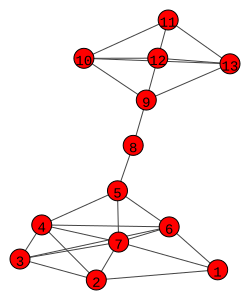

In [ ]:
igraph.drawing.plot(test_igraph, bbox=[0, 0, 250, 300],
                    vertex_label=test_igraph.vs()['name'])

Function `mcode` takes a graph adjacency list `adj_list` and a float parameter `vwp` (vertex weight probability), and returns a list of cluster assignments (of length equal to the number of clusters).  Adapted from code written by True Price at UNC Chapel Hill [(link to original code on GitHub)](https://github.com/trueprice/python-graph-clustering/blob/master/src/mcode.py).  Formatted to PEP8 using the `autopep8` tool.

In [ ]:
def mcode(adj_list: List[List[int]], vwp: float):

    # Initialization
    N = len(adj_list)
    weights = [1.]*N  # this list will hold the vertex weights
    res_clusters = []  # this list will hold the clusters (lists of vertex IDs)

    # construct an "adjacency list-of-sets"
    edges = [set(adj_list[i]) for i in range(0, N)]

    # Stage 1: Vertex Weighting
    for i, i_neighbors in enumerate(edges):
        neighborhood = {i} | i_neighbors

        # if node has only one neighbor, we know everything we need to know
        if len(neighborhood) <= 2:
            continue

        # see if larger k-cores exist
        k = 1  # highest valid k-core
        while neighborhood:
            k_core = neighborhood.copy()
            while True:
                invalid_nodes = {n for n in neighborhood
                                 if len(edges[n] & neighborhood) <= k}
                neighborhood -= invalid_nodes
                if not (invalid_nodes and neighborhood):
                    break
            k += 1  # on exit, k will be one greater than we want

        # vertex weight = k-core number * density of k-core
        kcs = len(k_core)
        weights[i] = (k - 1) * (sum(len(edges[n] & k_core) for n in k_core) /
                               (kcs * (kcs - 1)))

    # -----------------------------------------
    # Stage 2: Molecular Complex Prediction

    # initialize stuff for stage 2
    unvisited = set(range(0, N))  # the set of vertex IDs not yet visited

    # iterate over vertex IDs starting with the highest-weight vertex first:
    # (note: numpy.argsort is much faster than using sorted+enumerate)
    for seed in np.argsort(-np.array(weights)):
        # don't use the same vertex twice, as a seed for a cluster:
        if seed not in unvisited:
            continue

        # initially, the frontier (and the cluster) is just the seed vertex
        cluster = {seed}
        frontier = cluster.copy()

        # `w` is the minimum weight cutoff
        w = weights[seed] * vwp

        # while there are vertices in the frontier set
        while frontier:
            # add the frontier vertices to the cluster, if they are not already in it
            cluster.update(frontier)

            # remove the frontier vertices from the `unvisited` set, since we have visited them
            unvisited -= frontier

            # make a new set `frt_plus_neighb` including neighbors of all vertices
            # in `frontier` (using a double list comprehension or set.union)
            frt_plus_neighb = set(e for n in frontier for e in edges[n]) | frontier
            # alternate code: frt_plus_neighb = set.union(*[edges[n] for n in frontier]) | frontier

            # make a new `frontier` set as unvisited vertices in `frt_plus_neighb`
            # that have sufficiently high weight (greater than w)
            frontier = {n for n in (frt_plus_neighb & unvisited)
                        if weights[n] > w}

        # haircut: only keep 2-core complexes
        invalid_nodes = True
        while invalid_nodes and cluster:
            invalid_nodes = {n for n in cluster
                             if len(edges[n] & cluster) < 2}
            cluster -= invalid_nodes

        if cluster:
            res_clusters.append(list(cluster))

    return(res_clusters)


How would you implement argsort on a python `list` type, in descending order, without having to use `lambda` or `__getitem__`, and without using `numpy`?

In [ ]:
testlist = [1.3, 2.8, 2.0]
print(testlist)
sorted_inds = list(map(operator.itemgetter(1),
                       sorted(((v, i) for i, v in enumerate(testlist)),
                               reverse=True)))
print(sorted_inds)

[1.3, 2.8, 2.0]
[1, 2, 0]


Run mcode on the adjacency list for your toy graph, with `vwp=0.3`. How many clusters did it find? Do the cluster memberships make sense?

In [ ]:
clusters_node_ids = mcode(test_igraph.get_adjlist(), 0.3)
[[test_igraph.vs["name"][i] for i in cluster_nodes] for cluster_nodes in clusters_node_ids]

[['1', '2', '6', '7', '4', '3', '5'], ['9', '10', '12', '13', '11']]

Now see if you can load in a larger graph (the yeast protein-protein interaction network, obtained from the supplementary data that accompanied the Krogan et&nbsp;al. paper that was in the assigned reading for today's class session) in edge-list (SIF) format. We will download the network from the URL https://csx46.s3-us-west-2.amazonaws.com/krogan-yeast-ppi-network.sif.

In [ ]:
!curl https://csx46.s3-us-west-2.amazonaws.com/krogan-yeast-ppi-network.sif > krogan-yeast-ppi-network.sif

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75826  100 75826    0     0   130k      0 --:--:-- --:--:-- --:--:--  130k


Load the Krogan et al. network edge-list data as a Pandas data frame

In [ ]:
edge_list = pd.read_csv("krogan-yeast-ppi-network.sif",
                        sep="\t",
                        names=["protein1","protein2"])

Make an igraph graph and print its summary

In [ ]:
krogan_graph = igraph.Graph.TupleList(edge_list.values.tolist(), directed=False)
krogan_graph.summary()

'IGRAPH UN-- 2674 7079 -- \n+ attr: name (v)'

Run mcode on your graph with `vwp=0.1`

In [ ]:
krogan_clusters = mcode(krogan_graph.get_adjlist(), 0.1)

Get the cluster sizes

In [ ]:
[len(cluster) for cluster in krogan_clusters]

[905, 4, 251, 3, 3, 3, 3, 4, 3, 3, 3, 4, 5]